In [1]:
import pandas as pd

# Load the dataset
file_path = '/content/2012-2014Power.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe
df_head = df.head()
print('Dataframe head:')
print(df_head)

Dataframe head:
              Hour_End        COAST        EAST     FAR_WEST       NORTH  \
0  2012-01-01 01:00:00  7748.160500  878.438488  1289.746813  652.153054   
1  2012-01-01 02:00:00  7559.728089  839.092904  1294.272245  643.483530   
2  2012-01-01 03:00:00  7337.789042  817.995707  1296.491345  631.940923   
3  2012-01-01 04:00:00  7161.895539  814.967883  1297.417294  631.428520   
4  2012-01-01 05:00:00  6984.460743  843.952578  1309.534911  640.892563   

       NORTH_C     SOUTHERN      SOUTH_C        WEST        ERCOT  ...  \
0  8648.989316  2105.379142  4162.162310  849.000892  26334.03052  ...   
1  8553.212708  2047.755534  4070.416593  845.097364  25853.05897  ...   
2  8461.317967  1961.909818  3946.994332  840.902849  25295.34198  ...   
3  8438.693857  1893.148232  3884.929253  845.452257  24967.93284  ...   
4  8565.433348  1867.358425  3911.610238  862.369386  24985.61219  ...   

   Dew Point  DHI  GHI  Relative Humidity  DNI  Solar Zenith Angle  \
0        7.9

In [2]:
# Check for inconsistencies in date and time notation

# Convert the 'Hour_End' column to datetime and catch any errors
pd.to_datetime(df['Hour_End'], errors='coerce').isnull().sum()

0

In [3]:
# Check for missing or inconsistent data in power consumption and weather columns
missing_data = df.isnull().sum()
print('Missing data counts per column:')
print(missing_data)

Missing data counts per column:
Hour_End                                       0
COAST                                          0
EAST                                           0
FAR_WEST                                       0
NORTH                                          0
NORTH_C                                        0
SOUTHERN                                       0
SOUTH_C                                        0
WEST                                           0
ERCOT                                          0
Temperature                                    0
Dew Point                                      0
DHI                                            0
GHI                                            0
Relative Humidity                              0
DNI                                            0
Solar Zenith Angle                             0
Precipitable Water                             0
Pressure                                       0
Wind Speed                           

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Selecting numerical columns for normalization
numerical_cols = df.columns.drop('Hour_End')

# Initializing the MinMaxScaler
scaler = MinMaxScaler()

# Fitting the scaler to the numerical columns and transforming the data
df_normalized = pd.DataFrame(scaler.fit_transform(df[numerical_cols]), columns=numerical_cols)

# Adding the 'Hour_End' column back to the normalized dataframe
df_normalized['Hour_End'] = df['Hour_End']

# Displaying the head of the normalized dataframe to check the transformation
print('Head of the normalized dataframe:')
print(df_normalized.head())

Head of the normalized dataframe:
      COAST      EAST  FAR_WEST     NORTH   NORTH_C  SOUTHERN   SOUTH_C  \
0  0.104863  0.070038  0.100414  0.136596  0.086512  0.119199  0.078472   
1  0.089560  0.046315  0.103325  0.128342  0.081077  0.103567  0.067168   
2  0.071535  0.033595  0.104753  0.117354  0.075863  0.080279  0.051961   
3  0.057251  0.031769  0.105349  0.116866  0.074579  0.061625  0.044314   
4  0.042840  0.049245  0.113145  0.125876  0.081771  0.054629  0.047602   

       WEST     ERCOT  Temperature  ...  DHI  GHI  Relative Humidity  DNI  \
0  0.176511  0.085093     0.382353  ...  0.0  0.0           0.667532  0.0   
1  0.173339  0.074339     0.363445  ...  0.0  0.0           0.694017  0.0   
2  0.169930  0.061869     0.346639  ...  0.0  0.0           0.720710  0.0   
3  0.173627  0.054549     0.342437  ...  0.0  0.0           0.714790  0.0   
4  0.187376  0.054944     0.346639  ...  0.0  0.0           0.680827  0.0   

   Solar Zenith Angle  Precipitable Water  Pressure 

In [5]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Assuming 'Hour_End' is the datetime column and should be set as index
# First, converting 'Hour_End' to datetime format
df_normalized['Hour_End'] = pd.to_datetime(df_normalized['Hour_End'])

# Setting 'Hour_End' as the index
df_normalized.set_index('Hour_End', inplace=True)

# Splitting the dataset into features and target variable
# Assuming 'ERCOT' as the target variable for prediction
X = df_normalized.drop('ERCOT', axis=1)
y = df_normalized['ERCOT']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

print('Training set size:', X_train.shape)
print('Testing set size:', X_test.shape)

Training set size: (21023, 19)
Testing set size: (5256, 19)


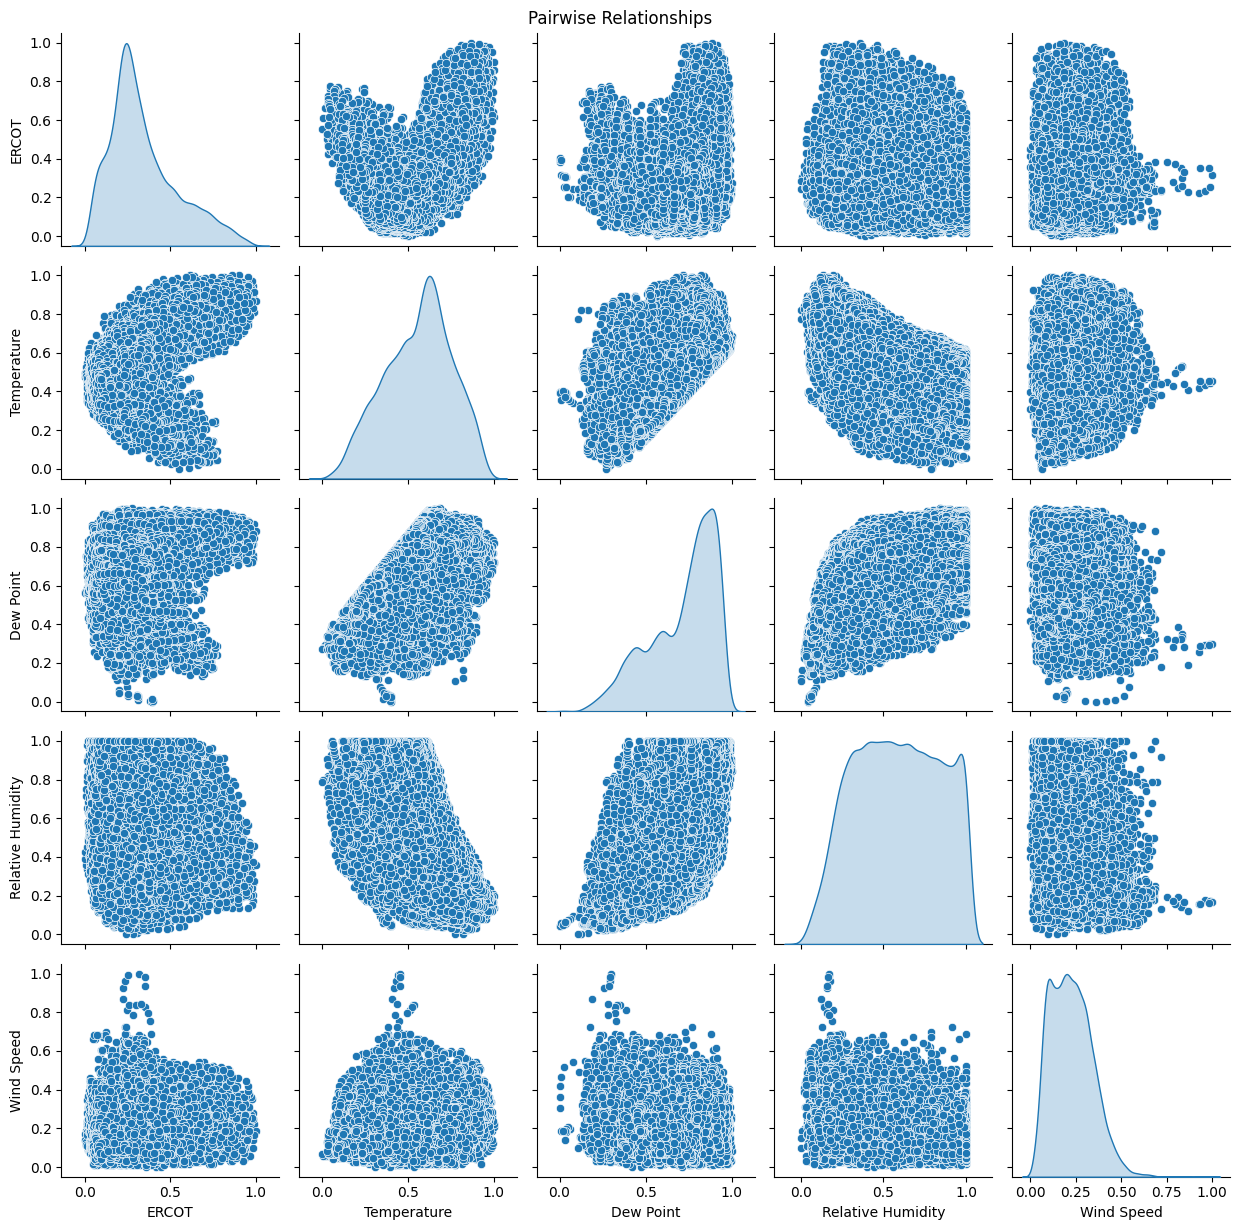

In [6]:
# Resetting the index to ensure there are no duplicates or issues
# This is a common step before performing operations that might be sensitive to index issues
df_normalized.reset_index(inplace=True)

# Attempting the pairplot visualization again
import seaborn as sns
import matplotlib.pyplot as plt

cols_to_analyze = ['ERCOT', 'Temperature', 'Dew Point', 'Relative Humidity', 'Wind Speed']

# Plotting pairwise relationships using pairplot
sns.pairplot(df_normalized[cols_to_analyze], diag_kind='kde')
plt.suptitle('Pairwise Relationships')
plt.tight_layout()
plt.show()

In [7]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np

# LSTM expects data to be in [samples, time steps, features] format.
# Currently, our X_train and X_test are in [samples, features] format.

# Defining the number of inputs (time steps) and features
n_input = 24  # Number of time steps
n_features = X_train.shape[1]  # Number of features

# Reshaping the input to fit the LSTM model
train_generator = TimeseriesGenerator(X_train.values, y_train.values, length=n_input, batch_size=6)
test_generator = TimeseriesGenerator(X_test.values, y_test.values, length=n_input, batch_size=6)

# Example of generated data shape
X, y = train_generator[0]
print('Generated data shape:', X.shape)
print('Generated target shape:', y.shape)

Generated data shape: (6, 24, 19)
Generated target shape: (6,)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               48000     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 48101 (187.89 KB)
Trainable params: 48101 (187.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
3500/3500 [==============================] - 55s 15ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 2/10
3500/3500 [==============================] - 56s 16ms/step - loss: 3.8751e-04 - val_loss: 3.6934e-04
Epoch 3/10
3500/3500 [==============================] - 53s 15ms/step - loss: 2.9841e-04 - val_loss: 1.9925e-04
Epoch 4/10
3500/3500 [==============================] - 53s 15ms/step - loss: 2.4905e-

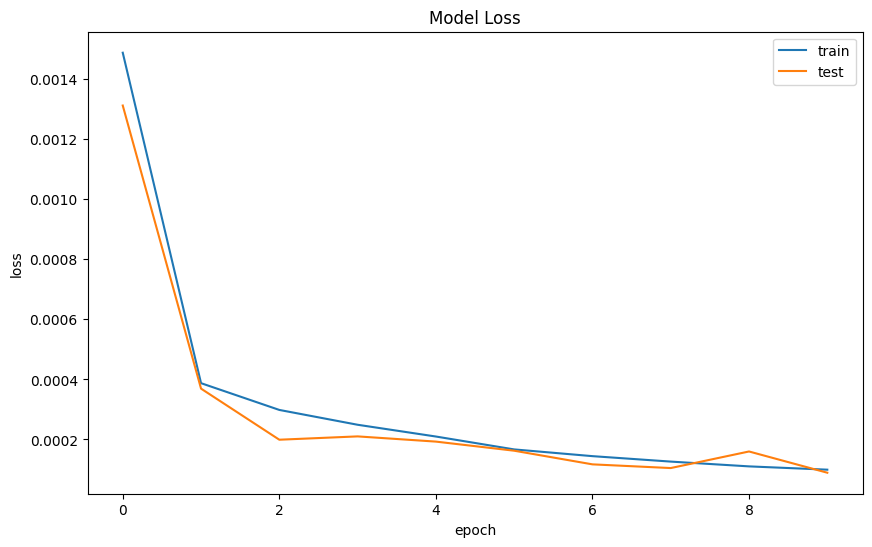

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Defining the LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Summary of the model
model.summary()

# Training the model
history = model.fit(train_generator, epochs=10, verbose=1, validation_data=test_generator)

# Plotting the training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()